In [1]:
import findspark
findspark.init("D:/Code/Spark/spark-2.3.2-bin-hadoop2.7")

from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import year, month, dayofmonth, hour, date_format, to_timestamp, unix_timestamp
from pyspark.sql.functions import radians, sin, cos, atan2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [3]:
sc = SparkContext()
sqlsc = SQLContext(sc)
spark = sqlsc.sparkSession

## 1. Read and transform to parquet

In [4]:
#df1 = sqlsc.read.option('sep',',').option('header','true').option('inferSchema','true').csv('train.csv')

In [5]:
#dt = spark.createDataFrame(df1.rdd)

In [6]:
#dt.write.parquet('train.parquet')

## 2. Load data from parquet

In [7]:
# Importing dataset from parquet folder
df = spark.read.load("train.parquet")

In [8]:
df.show(5)

+-------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|2011-07-24 00:10:00|        5.7|2011-07-24 00:10:...|      -73.981645|      40.743598|       -73.980725|       40.730052|              3|
|2011-08-20 18:03:04|        4.1|2011-08-20 18:03:...|      -73.973492|      40.752369|       -73.966947|        40.76108|              1|
|2012-10-25 10:16:35|        9.5|2012-10-25 10:16:...|       -73.97368|       40.76371|       -73.989415|       40.757887|              1|
|2013-08-01 07:33:00|       15.5|2013-08-01 07:33:...|      -73.966823|      40.788912|       -73.976017|       40.744635|              3|
|2013-08-16 23:19:00|      

In [9]:
# Check type of each variable
df.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: long (nullable = true)



In [10]:
print('There are {} observations in the dataset'.format(df.count()))

There are 55423856 observations in the dataset


In [11]:
# Associate the dataframe python with a table SQL  
sqlsc.registerDataFrameAsTable(df, 'train')

## 3. Exploratory Data Analysis (EDA)

### 3.1. Preparing a subset of dataset to do EDA

In [12]:
# Randomly choose ~1.100.000 rows to do EDA
sqlsc.sql('SELECT * FROM train WHERE rand(167) <= .02').cache().createOrReplaceTempView('train')

In [13]:
# Check again number of rows in the dataset
sqlsc.sql('SELECT COUNT(key) AS number_of_rows FROM train').show()

+--------------+
|number_of_rows|
+--------------+
|       1106666|
+--------------+



In [14]:
# Check number of missing values each variable
sqlsc.sql('SELECT sum(CASE WHEN key IS NULL THEN 1 ELSE 0 END) key, sum(CASE WHEN fare_amount IS NULL THEN 1 ELSE 0 END) fare_amount, sum(CASE WHEN pickup_datetime IS NULL THEN 1 ELSE 0 END) pickup_datetime, sum(CASE WHEN pickup_longitude IS NULL THEN 1 ELSE 0 END) pickup_longitude, sum(CASE WHEN pickup_latitude IS NULL THEN 1 ELSE 0 END) pickup_latitude, sum(CASE WHEN dropoff_longitude IS NULL THEN 1 ELSE 0 END) dropoff_longitude, sum(CASE WHEN dropoff_latitude IS NULL THEN 1 ELSE 0 END) dropoff_latitude, sum(CASE WHEN passenger_count IS NULL THEN 1 ELSE 0 END) passenger_count FROM train').show()

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|                6|               6|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



In [15]:
# Missing values not much, simply remove it
spark.sql('SELECT * FROM train '
          'WHERE dropoff_longitude IS NOT NULL '
          'AND dropoff_latitude IS NOT NULL').cache().createOrReplaceTempView('train')

In [16]:
# Check `fare_amount` how many negative values?
sqlsc.sql('SELECT COUNT(fare_amount) AS fare_amount_negative FROM train WHERE fare_amount < 0').show()

+--------------------+
|fare_amount_negative|
+--------------------+
|                  36|
+--------------------+



In [17]:
# Number of `fare_amount` < 0 not much, simply remove it:
sqlsc.sql('SELECT * FROM train WHERE fare_amount >= 0').cache().createOrReplaceTempView('train')

In [18]:
# Normally 7 passengers in a taxi, then check how many cases:
sqlsc.sql('SELECT COUNT(passenger_count) AS num_passenger_pass_7 FROM train WHERE passenger_count > 7').show()

+--------------------+
|num_passenger_pass_7|
+--------------------+
|                   4|
+--------------------+



In [19]:
# we'll remove them:
sqlsc.sql('SELECT * FROM train WHERE passenger_count <= 7').cache().createOrReplaceTempView('train')

In [20]:
# Check information: New York City latitude between -90 and 90, longitude from -180 to 180 
# Then, count number of obs pickup_latitude > 90 or pickup_latitude < -90
sqlsc.sql('SELECT COUNT(key) AS check_pickup_latitude FROM train WHERE pickup_latitude > 90 OR pickup_latitude < -90').show()

+---------------------+
|check_pickup_latitude|
+---------------------+
|                   24|
+---------------------+



In [21]:
# Check count number of obs dropoff_latitude > 90 or dropoff_latitude < -90
sqlsc.sql('SELECT COUNT(key) AS check_dropoff_latitude FROM train WHERE dropoff_latitude > 90 OR dropoff_latitude < -90').show()

+----------------------+
|check_dropoff_latitude|
+----------------------+
|                    18|
+----------------------+



In [22]:
# Check count number of obs dropoff_longitude > 180 OR dropoff_longitude < -180
sqlsc.sql('SELECT COUNT(key) AS check_dropoff_longitude FROM train WHERE dropoff_longitude > 180 OR dropoff_longitude < -180').show()

+-----------------------+
|check_dropoff_longitude|
+-----------------------+
|                     23|
+-----------------------+



In [23]:
# Check count number of obs pickup_longitude > 180 OR pickup_longitude < -180
sqlsc.sql('SELECT COUNT(key) AS check_pickup_longitude FROM train WHERE pickup_longitude > 180 OR pickup_longitude < -180').show()

+----------------------+
|check_pickup_longitude|
+----------------------+
|                    23|
+----------------------+



In [24]:
# we'll remove them:
sqlsc.sql('SELECT * FROM train WHERE pickup_latitude BETWEEN -90 AND 90').cache().createOrReplaceTempView('train')
sqlsc.sql('SELECT * FROM train WHERE dropoff_latitude BETWEEN -90 AND 90').cache().createOrReplaceTempView('train')
sqlsc.sql('SELECT * FROM train WHERE pickup_longitude BETWEEN -180 AND 180').cache().createOrReplaceTempView('train')
sqlsc.sql('SELECT * FROM train WHERE dropoff_longitude BETWEEN -180 AND 180').cache().createOrReplaceTempView('train')

In [25]:
# Convert pickup_datetime to datetime type
sqlsc.sql('SELECT key, fare_amount, TO_TIMESTAMP(CAST(UNIX_TIMESTAMP(pickup_datetime, "yyyy-MM-dd HH:mm:ss") AS TIMESTAMP)) AS pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count FROM train').cache().createOrReplaceTempView('train')

In [26]:
# Define variables `Year`, `Month`, `Date`, `Day of week`, `Hour`
sqlsc.sql('SELECT key, fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, year(pickup_datetime) as Year, month(pickup_datetime) as Month, dayofmonth(pickup_datetime) as Date, date_format(pickup_datetime, "E") as DayOfWeek, hour(pickup_datetime) AS Hour FROM train').cache().createOrReplaceTempView('train')

In [27]:
# Compute distance given latitude and longitude 2 points in map:
# R = 6371: radius of earth in kilometers
sqlsc.sql('SELECT *, radians(pickup_latitude) AS phi1, radians(dropoff_latitude) AS phi2, radians(dropoff_latitude - pickup_latitude) AS delta_phi, radians(dropoff_longitude - pickup_longitude) AS delta_lambda FROM train').cache().createOrReplaceTempView('train')

In [28]:
# Compute a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
sqlsc.sql('SELECT *, power(sin(delta_phi/2), 2) + cos(phi1)*cos(phi2)*power(sin(delta_lambda/2), 2) AS a FROM train').cache().createOrReplaceTempView('train')

In [29]:
# Compute distance d = R * 2 * atan2( √a, √(1−a) )
sqlsc.sql('SELECT *, 6371*2*atan2(sqrt(a), sqrt(1-a)) AS distance FROM train').cache().createOrReplaceTempView('train')

In [30]:
# Choose only useful variables
sqlsc.sql('SELECT key, fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, Year, Month, Date, DayOfWeek, Hour, distance FROM train').cache().createOrReplaceTempView('train')

In [31]:
# Drop missing values again
spark.sql('SELECT * FROM train WHERE Year IS NOT NULL AND Month IS NOT NULL AND Date IS NOT NULL AND DayOfWeek IS NOT NULL AND Hour IS NOT NULL').cache().createOrReplaceTempView('train')

In [32]:
# Perform 5 obs
sqlsc.sql('SELECT * FROM train').show(5)

+-------------------+-----------+------------------+-----------------+------------------+----------------+---------------+----+-----+----+---------+----+------------------+
|                key|fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude|dropoff_latitude|passenger_count|Year|Month|Date|DayOfWeek|Hour|          distance|
+-------------------+-----------+------------------+-----------------+------------------+----------------+---------------+----+-----+----+---------+----+------------------+
|2015-02-16 23:18:00|        8.0|-73.98243713378906|40.77253341674805|-73.96524047851562|40.7911376953125|              1|2015|    2|  16|      Mon|  23| 2.525066616284672|
|2014-05-01 17:54:38|       20.5|        -74.000388|        40.723818|        -73.994725|         40.7504|              1|2014|    5|   1|      Thu|  17| 2.994045454411657|
|2014-07-18 06:57:51|        6.0|        -73.991425|        40.749792|        -73.977773|        40.75784|              1|2014|    7|  

In [33]:
sqlsc.sql('DESCRIBE train').show()

+-----------------+---------+-------+
|         col_name|data_type|comment|
+-----------------+---------+-------+
|              key|timestamp|   null|
|      fare_amount|   double|   null|
| pickup_longitude|   double|   null|
|  pickup_latitude|   double|   null|
|dropoff_longitude|   double|   null|
| dropoff_latitude|   double|   null|
|  passenger_count|   bigint|   null|
|             Year|      int|   null|
|            Month|      int|   null|
|             Date|      int|   null|
|        DayOfWeek|   string|   null|
|             Hour|      int|   null|
|         distance|   double|   null|
+-----------------+---------+-------+



In [34]:
#Transférer dans mon environnement Python le dataframe qui est dans l'environnement Spark
#train = sqlsc.sql('SELECT * FROM train').toPandas()

### 3.2. Analyse predictor variable: `fare_amount`

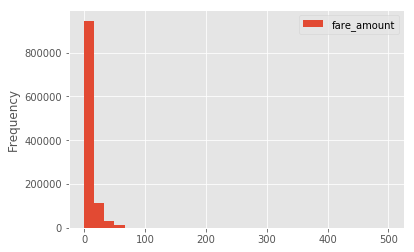

In [35]:
# Check distribution of `fare_amount`:
sqlsc.sql('SELECT fare_amount FROM train').toPandas().plot.hist(bins = 30)

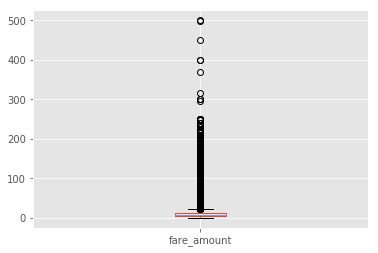

In [36]:
sqlsc.sql('SELECT fare_amount FROM train').toPandas().plot.box()

In [37]:
# Check very big values `fare_amount`:
sqlsc.sql('SELECT COUNT(fare_amount) FROM train WHERE fare_amount > 300').show()

+------------------+
|count(fare_amount)|
+------------------+
|                 8|
+------------------+



In [38]:
sqlsc.sql('SELECT COUNT(fare_amount) FROM train WHERE fare_amount >= 100').show()

+------------------+
|count(fare_amount)|
+------------------+
|               463|
+------------------+



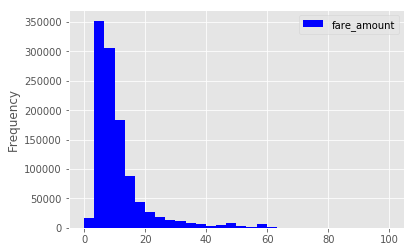

In [39]:
sqlsc.sql('SELECT fare_amount FROM train WHERE fare_amount < 100').toPandas().plot.hist(bins = 30, color = 'blue')

**Note**: `fare_amount` very right skewed -> fare taxi focus on interval 0-60 $$, only ~ 0.04% observations whose value > 100$

### 3.3. Analyse `passenger_count` variable

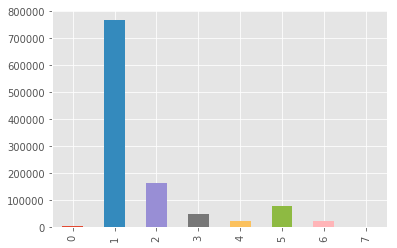

In [40]:
# Count number of obs each type of passenger
sqlsc.sql('SELECT passenger_count FROM train').toPandas()['passenger_count'].value_counts().sort_index().plot.bar()

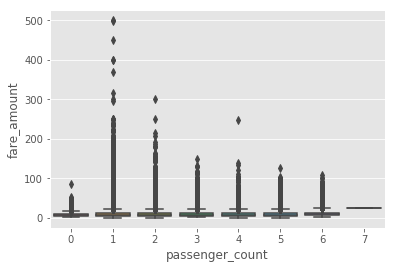

In [41]:
sns.boxplot(x = 'passenger_count', y = 'fare_amount', data = sqlsc.sql('SELECT fare_amount, passenger_count FROM train').toPandas())

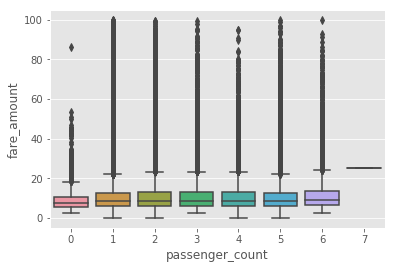

In [42]:
sns.boxplot(x = 'passenger_count', y = 'fare_amount', data = sqlsc.sql('SELECT fare_amount, passenger_count FROM train WHERE fare_amount < 100').toPandas())

**Note:** Median and 25%, 75% quantiles of each type of passenger_count seem to be similar

### 3.4. Analyse `Year` variable

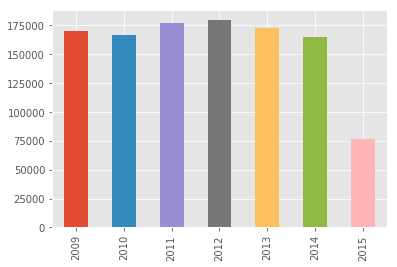

In [43]:
sqlsc.sql('SELECT Year FROM train').toPandas()['Year'].value_counts().sort_index().plot.bar()

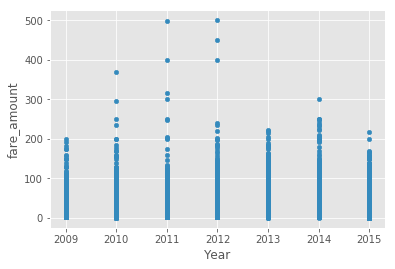

In [44]:
sqlsc.sql('SELECT fare_amount, Year FROM train').toPandas().plot.scatter(x = 'Year', y = 'fare_amount')

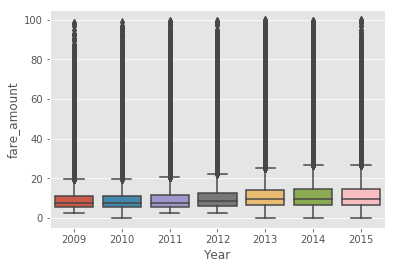

In [45]:
sns.boxplot(x = 'Year', y = 'fare_amount', data = sqlsc.sql('SELECT fare_amount, Year FROM train WHERE fare_amount < 100').toPandas())

**Note:** fare_amount average seems to increase by Year

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


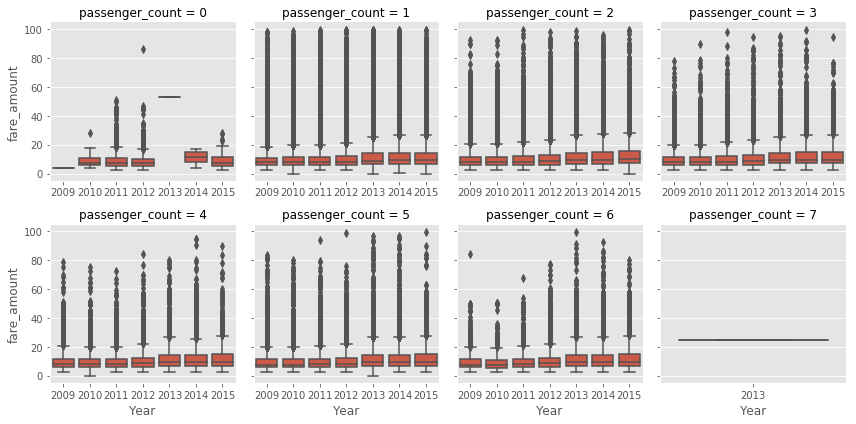

In [46]:
g = sns.FacetGrid(sqlsc.sql('SELECT fare_amount, passenger_count, Year FROM train WHERE fare_amount < 100').toPandas(), col = 'passenger_count', col_wrap = 4, sharex = False, sharey = True)
g.map(sns.boxplot, 'Year', 'fare_amount')

**Note:** This tendance of increment by Year is kept/not changed each type of passenger_count

### 3.5. Analyse `Month` variable

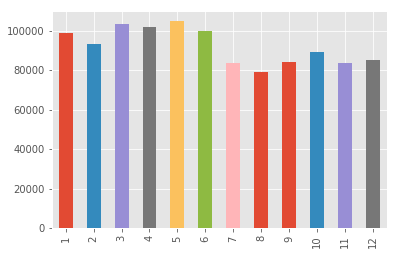

In [47]:
sqlsc.sql('SELECT Month FROM train').toPandas()['Month'].value_counts().sort_index().plot.bar()

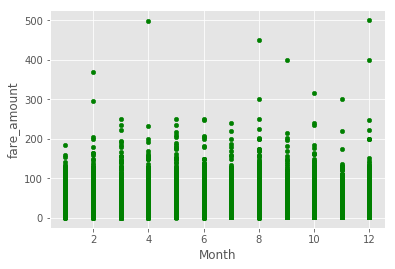

In [48]:
sqlsc.sql('SELECT fare_amount, Month FROM train').toPandas().plot.scatter(x = 'Month', y = 'fare_amount', color = 'green')

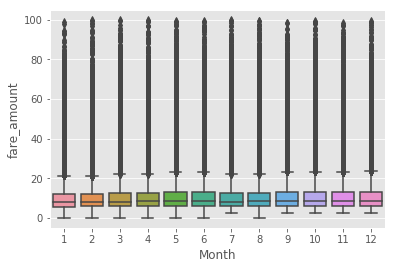

In [49]:
sns.boxplot(x = 'Month', y = 'fare_amount', data = sqlsc.sql('SELECT fare_amount, Month FROM train WHERE fare_amount < 100').toPandas())

### 3.6. Analyse `Date` variable

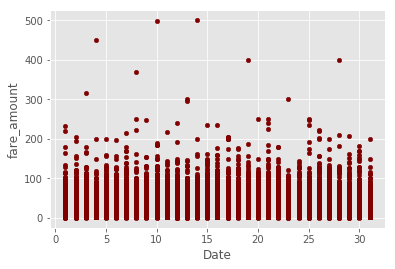

In [50]:
sqlsc.sql('SELECT fare_amount, Date FROM train').toPandas().plot.scatter(x = 'Date', y = 'fare_amount', color = 'maroon')

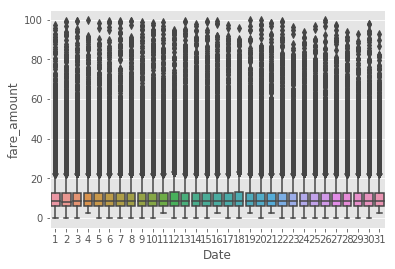

In [51]:
sns.boxplot(x = 'Date', y = 'fare_amount', data = sqlsc.sql('SELECT fare_amount, Date FROM train WHERE fare_amount < 100').toPandas())

### 3.7. Analyse `DayOfWeek` variable

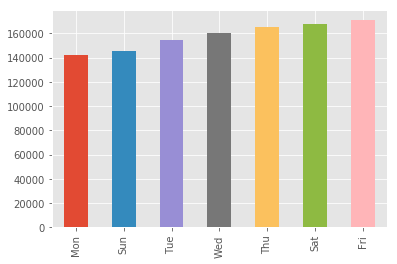

In [52]:
sqlsc.sql('SELECT DayOfWeek FROM train').toPandas()['DayOfWeek'].value_counts().sort_values().plot.bar()

In [53]:
# Change value's DayOfWeek: Mon = 0, Tue = 1, Wed = 2, Thu = 3, Fri = 4, Sat = 5, Sun = 6
sqlsc.sql('SELECT key, fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, Year, Month, Date, CASE DayOfWeek WHEN "Mon" THEN 0 WHEN "Tue" THEN 1 WHEN "Wed" THEN 2 WHEN "Thu" THEN 3 WHEN "Fri" THEN 4 WHEN "Sat" THEN 5 WHEN "Sun" THEN 6 END AS DayOfWeek, Hour, distance FROM train').cache().createOrReplaceTempView('train')

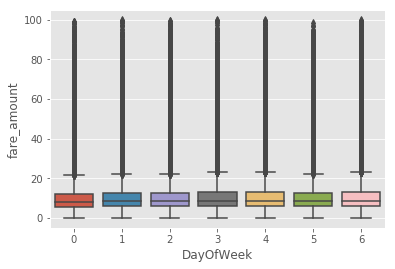

In [54]:
sns.boxplot(x = 'DayOfWeek', y = 'fare_amount', data = sqlsc.sql('SELECT fare_amount, DayOfWeek FROM train WHERE fare_amount < 100').toPandas())

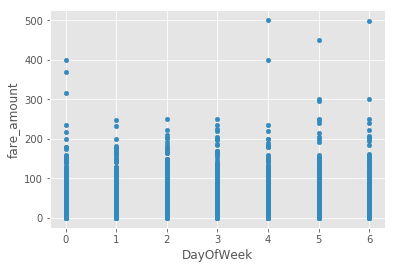

In [55]:
sqlsc.sql('SELECT fare_amount, DayOfWeek FROM train').toPandas().plot.scatter(x = 'DayOfWeek', y = 'fare_amount')

In [56]:
# Create a new variable: Weekend take 1 if DayOfWeek = Sat or Sun, 0 otherwise 
sqlsc.sql('SELECT key, fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, Year, Month, Date, DayOfWeek, CASE DayOfWeek WHEN 5 THEN 1 WHEN 6 THEN 1 ELSE 0 END AS Weekend, Hour, distance FROM train').cache().createOrReplaceTempView('train')

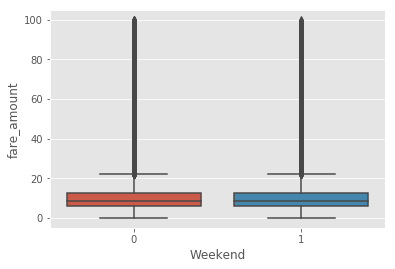

In [57]:
sns.boxplot(x = 'Weekend', y = 'fare_amount', data = sqlsc.sql('SELECT fare_amount, Weekend FROM train WHERE fare_amount < 100').toPandas())

### 3.8. Analyse `Hour` variable

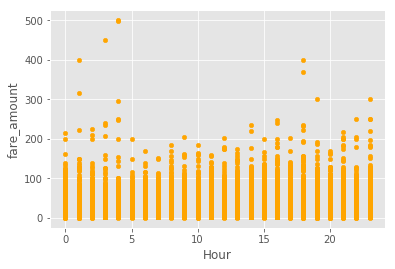

In [58]:
sqlsc.sql('SELECT fare_amount, Hour FROM train').toPandas().plot.scatter(x = 'Hour', y = 'fare_amount', color = 'orange')

In [59]:
# Create a new variable: rush_hour take 1 if Hour from 6:00 am to 20:00 pm, 0 otherwise 
sqlsc.sql('SELECT key, fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, Year, Month, Date, DayOfWeek, Weekend, Hour, CASE WHEN Hour >= 6 AND Hour <= 20 THEN 1 ELSE 0 END AS rush_hour, distance FROM train').cache().createOrReplaceTempView('train')

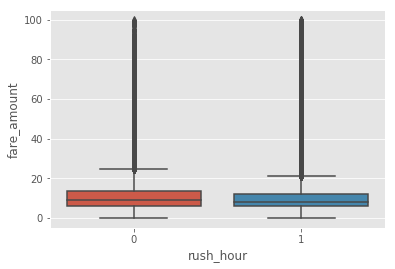

In [60]:
sns.boxplot(x = 'rush_hour', y = 'fare_amount', data = sqlsc.sql('SELECT fare_amount, rush_hour FROM train WHERE fare_amount < 100').toPandas())

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


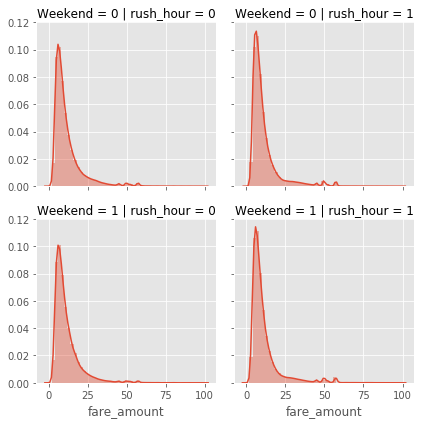

In [61]:
g = sns.FacetGrid(sqlsc.sql('SELECT fare_amount, Weekend, rush_hour FROM train WHERE fare_amount < 100').toPandas(), col = 'rush_hour', row = 'Weekend')
g.map(sns.distplot, 'fare_amount')

### 3.9. Analyse `distance` variable

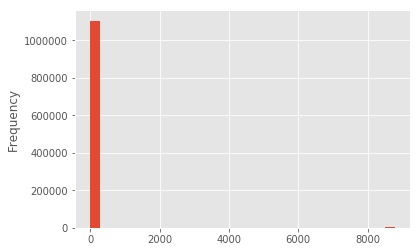

In [62]:
sqlsc.sql('SELECT distance FROM train').toPandas()['distance'].plot.hist(bins = 30)

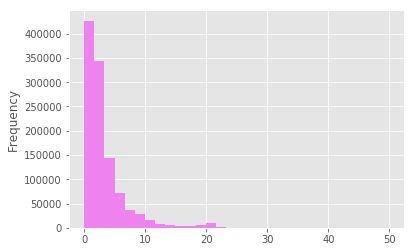

In [63]:
sqlsc.sql('SELECT distance FROM train WHERE distance < 50').toPandas()['distance'].plot.hist(bins = 30, color = 'violet')

In [64]:
sqlsc.sql('SELECT COUNT(distance) FROM train WHERE distance > 1000').show()

+---------------+
|count(distance)|
+---------------+
|           2211|
+---------------+



In [65]:
sqlsc.sql('SELECT COUNT(distance) FROM train WHERE distance > 50').show()

+---------------+
|count(distance)|
+---------------+
|           2670|
+---------------+



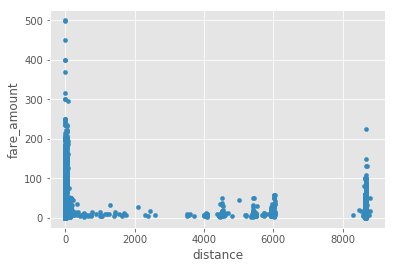

In [66]:
sqlsc.sql('SELECT fare_amount, distance FROM train').toPandas().plot.scatter(x = 'distance', y = 'fare_amount', linewidths = 0.2, edgecolors = 'face')

In [67]:
# Create a new variable: distance_bins 0-1km, 1-10km, 10-50km, >50km 
sqlsc.sql('SELECT key, fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, Year, Month, Date, DayOfWeek, Weekend, Hour, rush_hour, distance, CASE WHEN distance <= 1 THEN "0-1" WHEN distance > 1 AND distance <= 10 THEN "1-10" WHEN distance > 10 AND distance <= 50 THEN "10-50" ELSE ">50" END AS distance_bins FROM train').cache().createOrReplaceTempView('train')

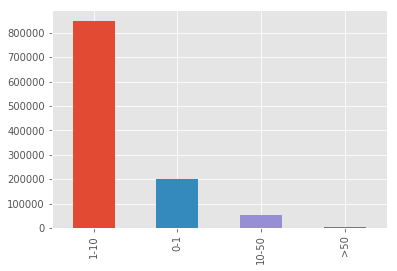

In [68]:
sqlsc.sql('SELECT distance_bins FROM train').toPandas()['distance_bins'].value_counts().plot.bar()

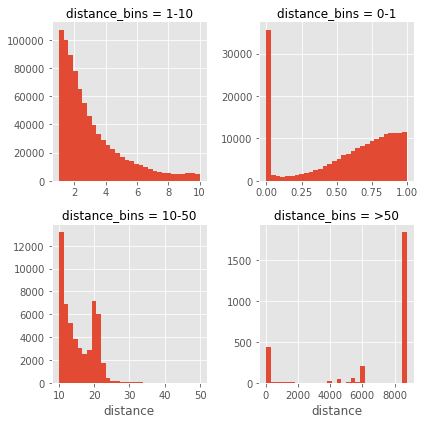

In [69]:
g = sns.FacetGrid(sqlsc.sql('SELECT distance, distance_bins FROM train').toPandas(), col = 'distance_bins', col_wrap = 2, sharex = False, sharey = False)
g.map(plt.hist, 'distance', bins = 30) 

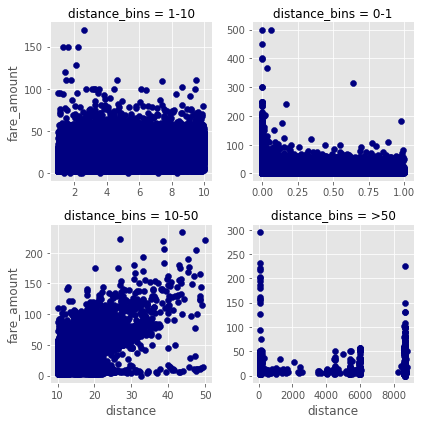

In [70]:
g = sns.FacetGrid(sqlsc.sql('SELECT fare_amount, distance, distance_bins FROM train').toPandas(), col = 'distance_bins', col_wrap = 2, sharex = False, sharey = False)
g.map(plt.scatter, 'distance', 'fare_amount', color = 'navy') 

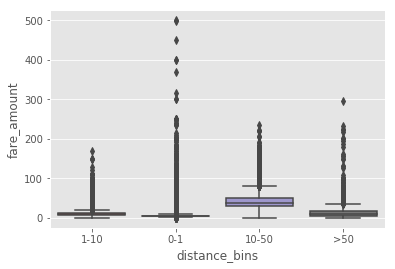

In [71]:
sns.boxplot(x = 'distance_bins', y = 'fare_amount', data = sqlsc.sql('SELECT fare_amount, distance_bins FROM train').toPandas())

**Check fare of taxi (cab) in New York City:** https://www.taxi-calculator.com/taxi-fare-new-york-city/259

- From Monday to Friday (6:00 am - 20:00 pm): Base fare 2.5 USD, 1.56USD/km, waiting time: 30 USD/h
- From Monday to Friday (20:00 pm - 06:00 am) and Week-end: Base fare 3.0 USD, 1.56 USD/km, waiting time: 30 USD/h.

## 4. Feature engineering

In [72]:
# Check number of obs whose values of distance = 0km and fare_amount < 2.5 USD, we cann't explain that
sqlsc.sql('SELECT COUNT(distance) FROM train WHERE distance = 0 AND fare_amount < 2.5').show()

+---------------+
|count(distance)|
+---------------+
|              6|
+---------------+



In [73]:
# Drop it
sqlsc.sql('SELECT * FROM train WHERE distance != 0 OR fare_amount >= 2.5').cache().createOrReplaceTempView('train')

In [74]:
sqlsc.sql('SELECT COUNT(distance) FROM train WHERE distance >= 0 AND distance <= 0.25').show()

+---------------+
|count(distance)|
+---------------+
|          43293|
+---------------+



In [75]:
# For 0 <= distance <= 0.25km and fare is too large (than expected), we can understand that there are cases that a taxi have to 
# wait clients. We need to impute these distances by formula: distance = (fare_amount - 2.5)/1.56 or (fare_amount - 3.0)/1.56
sqlsc.sql('SELECT key, fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, Year, Month, Date, DayOfWeek, Weekend, Hour, rush_hour, CASE WHEN distance >= 0 AND distance <= 0.25 AND Weekend = 0 AND rush_hour = 1 THEN (fare_amount - 2.5)/1.56 + 50*RAND() WHEN distance >= 0 AND distance <= 0.25 AND Weekend = 0 AND rush_hour = 0 THEN (fare_amount - 3.0)/1.56 + 50*RAND() WHEN distance >= 0 AND distance <= 0.25 AND Weekend = 1 THEN (fare_amount - 3.0)/1.56 + 50*RAND() ELSE distance END AS distance, distance_bins FROM train').cache().createOrReplaceTempView('train')

In [76]:
# We do the same way with observations whose distance > 300km
sqlsc.sql('SELECT key, fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, Year, Month, Date, DayOfWeek, Weekend, Hour, rush_hour, CASE WHEN distance >= 300 AND Weekend = 0 AND rush_hour = 1 THEN (fare_amount - 2.5)/1.56 + 50*RAND() WHEN distance >= 300 AND Weekend = 0 AND rush_hour = 0 THEN (fare_amount - 3.0)/1.56 + 50*RAND() WHEN distance >= 300 AND Weekend = 1 THEN (fare_amount - 3.0)/1.56 + 50*RAND() ELSE distance END AS distance, distance_bins FROM train').cache().createOrReplaceTempView('train')

In [77]:
# We do the same way with observations whose fare_amount = 0
sqlsc.sql('SELECT key, CASE WHEN fare_amount = 0 AND Weekend = 0 AND rush_hour = 1 THEN 1.56*distance + 2.5 + 20*RAND() WHEN fare_amount = 0 AND Weekend = 0 AND rush_hour = 0 THEN 1.56*distance + 3.0 + 20*RAND() WHEN fare_amount = 0 AND Weekend = 1 THEN 1.56*distance + 3.0 + 20*RAND() ELSE fare_amount END AS fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, Year, Month, Date, DayOfWeek, Weekend, Hour, rush_hour, distance FROM train').cache().createOrReplaceTempView('train')

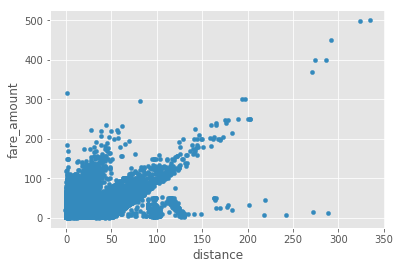

In [78]:
sqlsc.sql('SELECT fare_amount, distance FROM train').toPandas().plot.scatter(x = 'distance', y = 'fare_amount', linewidths = 0.2, edgecolors = 'face')

In [79]:
data = sqlsc.sql('SELECT fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, Year, Month, Date, DayOfWeek, Weekend, Hour, rush_hour, distance FROM train').cache()

## 5. Training

### 5.1. Model selection

In [80]:
train, val = data.randomSplit([0.95, 0.05], seed=12345)

In [81]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Year', 'Month', 'Date', 'DayOfWeek', 'Weekend', 'Hour', 'rush_hour', 'distance'], outputCol='features')

final_train = assembler.transform(train)

In [82]:
final_val = assembler.transform(val)

In [83]:
final_train

DataFrame[fare_amount: double, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, passenger_count: bigint, Year: int, Month: int, Date: int, DayOfWeek: int, Weekend: int, Hour: int, rush_hour: int, distance: double, features: vector]

### 5.2. Linear Regression

In [84]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol='fare_amount') #labelCol = y, LinearRegression: outil de régression, lr: régresseur

#Regression est le model
regression = lr.fit(final_train.selectExpr('features','fare_amount')) #La variable x doit s'appeler features

In [85]:
regression.summary.rootMeanSquaredError

8.061763361923482

In [86]:
regression.coefficients

DenseVector([-0.2685, -0.2095, -0.3421, -0.3837, 0.0987, 0.643, 0.1014, 0.0049, 0.0776, -0.4825, -0.01, 0.0675, 0.7972])

In [87]:
#On calcul les valeurs réelles et les valeurs prédite afin de calculer la performance
train_pred = regression.transform(final_train.selectExpr('features', 'fare_amount'))
val_pred = regression.transform(final_val.selectExpr('features', 'fare_amount'))

In [88]:
from pyspark.ml.evaluation import RegressionEvaluator

In [89]:
evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol= "fare_amount", metricName="rmse")

In [90]:
evaluator.evaluate(train_pred)

8.061763361923482

In [91]:
evaluator.evaluate(val_pred)

8.173648510531194

### 5.3. Decision Tree

In [92]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(labelCol="fare_amount", maxDepth=2, varianceCol="variance")

In [93]:
regression = dt.fit(final_train.selectExpr('features','fare_amount')) 

In [94]:
train_pred = regression.transform(final_train.selectExpr('features', 'fare_amount'))
val_pred = regression.transform(final_val.selectExpr('features', 'fare_amount'))

In [95]:
evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol= "fare_amount", metricName="rmse")

In [96]:
evaluator.evaluate(train_pred)

7.14909199213701

In [97]:
evaluator.evaluate(val_pred)

7.180958735402295

### 5.4. Random Forest

In [98]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="fare_amount", maxDepth=5)

In [99]:
regression = rf.fit(final_train.selectExpr('features','fare_amount')) 

In [100]:
train_pred = regression.transform(final_train.selectExpr('features', 'fare_amount'))
val_pred = regression.transform(final_val.selectExpr('features', 'fare_amount'))

In [101]:
evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol= "fare_amount", metricName="rmse")

In [102]:
evaluator.evaluate(train_pred)

5.544507315862115

In [103]:
evaluator.evaluate(val_pred)

5.513410120352309

In [104]:
feature_importances = regression.featureImportances

In [105]:
feature_names = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Year', 'Month', 'Date', 'DayOfWeek', 'Weekend', 'Hour', 'rush_hour', 'distance']

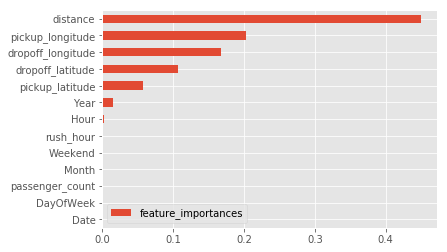

In [106]:
pd.DataFrame(data = list(feature_importances), columns = ['feature_importances'], index = feature_names).sort_values(by = 'feature_importances').plot.barh()